In [1]:
import numpy as np
from scipy.integrate import fixed_quad
import plotly.graph_objects as go
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares
import matplotlib.pyplot as plt
import os 
import time 

In [2]:
save_folder = 'run4'
n_points = 10000

lower_factor=0.7
upper_factor=1.3

minuit_tol = 0.001
minuit_errordef = 1 
minuit_strategy = 2

In [3]:
# Load experimental data
atlas_data = pd.read_csv('../../data/ens_atlas_difc0_2.dat', delim_whitespace=True, header=None)
totem_data = pd.read_csv('../../data/ens_totem_difc0_2.dat', delim_whitespace=True, header=None)

# Function to process data for each experiment
def process_data(data, energy_blocks):
    x_values = []
    y_values = []
    y_errors = []
    
    for start, end in energy_blocks:
        block = data.iloc[start:end] if end is not None else data.iloc[start:]
        x_values.append(block[0].values)
        y_values.append(block[1].values)
        y_errors.append(block[2].values)
    
    return x_values, y_values, y_errors

# Energy ranges for each experiment (7TeV, 8TeV, 13TeV)
atlas_blocks = [(0, 29), (29, 58), (58, None)]
totem_blocks = [(0, 65), (65, 118), (118, None)]

# Process data
x_atlas, y_atlas, yerr_atlas = process_data(atlas_data, atlas_blocks)
x_totem, y_totem, yerr_totem = process_data(totem_data, totem_blocks)

# Extract values by energy (index 0=7TeV, 1=8TeV, 2=13TeV)
x_7_atlas, y_7_atlas, yerr_7_atlas = x_atlas[0], y_atlas[0], yerr_atlas[0]
x_8_atlas, y_8_atlas, yerr_8_atlas = x_atlas[1], y_atlas[1], yerr_atlas[1]
x_13_atlas, y_13_atlas, yerr_13_atlas = x_atlas[2], y_atlas[2], yerr_atlas[2]

x_7_totem, y_7_totem, yerr_7_totem = x_totem[0], y_totem[0], yerr_totem[0]
x_8_totem, y_8_totem, yerr_8_totem = x_totem[1], y_totem[1], yerr_totem[1]
x_13_totem, y_13_totem, yerr_13_totem = x_totem[2], y_totem[2], yerr_totem[2]

/tmp/ipykernel_12778/1917071991.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  atlas_data = pd.read_csv('../../data/ens_atlas_difc0_2.dat', delim_whitespace=True, header=None)
/tmp/ipykernel_12778/1917071991.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  totem_data = pd.read_csv('../../data/ens_totem_difc0_2.dat', delim_whitespace=True, header=None)


In [4]:

b_0 = (33 - 6) / (12 * np.pi)
Lambda = 0.284  # ΛQCD in GeV
gamma_1 = 0.084
gamma_2 = 2.36
rho = 4.0
s0 = 1.0
alpha_prime = 0.25



ensemble_parameters = {
    'atlas': {
        'log': {
            'epsilon': 0.0753,
            'mg': 0.356,
            'a1': 1.373,
            'a2': 2.50
        },
        'pl': {
            'epsilon': 0.0753,
            'mg': 0.421,
            'a1': 1.517,
            'a2': 2.05
        }
    },
    'totem': {
        'log': {
            'epsilon': 0.0892,
            'mg': 0.380,
            'a1': 1.491,
            'a2': 2.77
        },
        'pl':{
            'epsilon': 0.0892,
            'mg': 0.447,
            'a1': 1.689,
            'a2': 1.7
        }
    }
}

ensemble_atlas = 'atlas'  
ensemble_totem = 'totem'

log_model_type = 'log'
pl_model_type = 'pl'   

def get_parameters_with_variations(ensemble_parameters, ensemble_name, model_type, lower_factor=lower_factor, upper_factor=upper_factor):
    # Obtém os parâmetros iniciais
    initial_params = ensemble_parameters[ensemble_name][model_type]
    
    # Cria as variações
    initial_params_low = {k: v * lower_factor for k, v in initial_params.items()}
    initial_params_high = {k: v * upper_factor for k, v in initial_params.items()}
    
    return initial_params, initial_params_low, initial_params_high

# Get parameters for selected configuration
initial_params_log_atlas = ensemble_parameters[ensemble_atlas][log_model_type]
initial_params_pl_atlas = ensemble_parameters[ensemble_atlas][pl_model_type]

# Para Atlas
initial_params_log_atlas, initial_params_low_log_atlas, initial_params_high_log_atlas = \
    get_parameters_with_variations(ensemble_parameters, ensemble_atlas, log_model_type)

initial_params_pl_atlas, initial_params_low_pl_atlas, initial_params_high_pl_atlas = \
    get_parameters_with_variations(ensemble_parameters, ensemble_atlas, pl_model_type)

# Para Totem
initial_params_log_totem, initial_params_low_log_totem, initial_params_high_log_totem = \
    get_parameters_with_variations(ensemble_parameters, ensemble_totem, log_model_type)

initial_params_pl_totem, initial_params_low_pl_totem, initial_params_high_pl_totem = \
    get_parameters_with_variations(ensemble_parameters, ensemble_totem, pl_model_type)



In [5]:
def m2_log(q2, mg):
    lambda_squared = Lambda ** 2
    rho_mg_squared = rho * mg ** 2
    ratio = np.log((q2 + rho_mg_squared) / lambda_squared) / np.log(rho_mg_squared / lambda_squared)
    return mg ** 2 * ratio ** (-1 - gamma_1)

def m2_pl(q2, mg):
    lambda_squared = Lambda ** 2
    rho_mg_squared = rho * mg ** 2
    ratio = np.log((q2 + rho_mg_squared) / lambda_squared) / np.log(rho_mg_squared / lambda_squared)
    return (mg ** 4 / (q2 + mg ** 2)) * ratio ** (gamma_2 - 1)


def G_p(q2, a1, a2):
    return np.exp(-(a1 * q2 + a2 * q2 ** 2))

def alpha_D(q2, mg, m2_func):
    m2 = m2_func(q2, mg)
    return 1.0 / (b_0 * (q2 + m2) * np.log((q2 + 4 * m2) / (Lambda ** 2)))

def T_1(k, q, phi, mg, a1, a2, m2_func):
    q2 = q 
    qk_cos = np.sqrt(q) * k * np.cos(phi)
    qk_plus_squared = q2 / 4 + qk_cos + k ** 2
    qk_minus_squared = q2 / 4 - qk_cos + k ** 2
    alpha_D_plus = alpha_D(qk_plus_squared, mg, m2_func)
    alpha_D_minus = alpha_D(qk_minus_squared, mg, m2_func)
    G0 = G_p(q2, a1, a2)
    return alpha_D_plus * alpha_D_minus * G0 ** 2

def T_2(k, q, phi, mg, a1, a2, m2_func):
    q2 = q 
    qk_cos = np.sqrt(q) * k * np.cos(phi)
    qk_plus_squared = q2 / 4 + qk_cos + k ** 2
    qk_minus_squared = q2 / 4 - qk_cos + k ** 2
    alpha_D_plus = alpha_D(qk_plus_squared, mg, m2_func)
    alpha_D_minus = alpha_D(qk_minus_squared, mg, m2_func)
    factor = q2 + 9 * abs(k ** 2 - q2 / 4)
    G0 = G_p(q2, a1, a2)
    G_minus = G_p(factor, a1, a2)
    return alpha_D_plus * alpha_D_minus * G_minus * (2 * G0 - G_minus)

def integrand(y, x, mg, a1, a2, m2_func, q_val, sqrt_s):
    k = sqrt_s * x 
    phi = 2 * np.pi * y
    jacobian = 2 * np.pi * sqrt_s 
    return k * (T_1(k, q_val, phi, mg, a1, a2, m2_func) - T_2(k, q_val, phi, mg, a1, a2, m2_func)) * jacobian 

def sigma_tot(amp_value, s):
    return amp_value.imag / s * 0.389379323

def amp_calculation(diff_T, s, epsilon, t):
    alpha_pomeron = 1.0 + epsilon + alpha_prime * t
    regge_factor = (s**alpha_pomeron) * 1/(s0**(alpha_pomeron-1))
    return 1j * 8 * regge_factor * diff_T  

def differential_sigma(amp_value, s):
    amp_squared = amp_value.imag * amp_value.imag
    denominator = (16 * np.pi * s**2)
    return amp_squared / denominator * 0.389379323


In [6]:
def model_function(x, eps, mg, a1, a2, sqrt_s, model_type='log'):

    # Definindo os parâmetros específicos do modelo
    params = {
        'epsilon': eps,
        'mg': mg,
        'a1': a1,
        'a2': a2
    }
    
    # Escolhendo a massa conforme o modelo
    m2 = m2_log if model_type == 'log' else m2_pl
    
    dif_sigma_lst = []
    
    for q2 in x:
        t = -q2
        
        def inner_integral(x_inner):
            return fixed_quad(
                lambda y: integrand(y, x_inner, params['mg'], params['a1'], 
                                  params['a2'], m2, q2, sqrt_s),
                0, 1,
                n=n_points
            )[0]

        integral_value = fixed_quad(
            inner_integral,
            0, 1,
            n=n_points
        )[0]

        diff_T = integral_value
        s = sqrt_s ** 2
        amp_value = amp_calculation(diff_T, s, params['epsilon'], t)
        dif_sigma_value = differential_sigma(amp_value, s)
        dif_sigma_lst.append(dif_sigma_value)
    
    return np.array(dif_sigma_lst)

In [7]:
def create_least_squares(x, y, yerr, sqrt_s, model_type):
    return LeastSquares(x, y, yerr, 
        lambda x, eps, mg, a1, a2: model_function(x, eps, mg, a1, a2, sqrt_s, model_type))

def total_cost(dataset, model_type):
    return sum([
        create_least_squares(*dataset[7000], 7000, model_type),
        create_least_squares(*dataset[8000], 8000, model_type),
        create_least_squares(*dataset[13000], 13000, model_type)
    ])

# Estrutura dos dados por experimento
atlas_data = {
    7000: (x_7_atlas, y_7_atlas, yerr_7_atlas),
    8000: (x_8_atlas, y_8_atlas, yerr_8_atlas),
    13000: (x_13_atlas, y_13_atlas, yerr_13_atlas)
}

totem_data = {
    7000: (x_7_totem, y_7_totem, yerr_7_totem),
    8000: (x_8_totem, y_8_totem, yerr_8_totem),
    13000: (x_13_totem, y_13_totem, yerr_13_totem)
}

# Custos totais
total_cost_log_atlas = total_cost(atlas_data, 'log')
total_cost_pl_atlas = total_cost(atlas_data, 'pl')
total_cost_log_totem = total_cost(totem_data, 'log')
total_cost_pl_totem = total_cost(totem_data, 'pl')


In [8]:
def otimization(total_cost_func, initial_params, initial_params_low, initial_params_high, model_type: str, ensemble: str):
    print(f"Iniciando otimização dos parâmetros usando LeastSquares para {model_type} em {ensemble.upper()}")

    start_time = time.time()
    
    m = Minuit(total_cost_func, 
               eps=initial_params['epsilon'],
               mg=initial_params['mg'],
               a1=initial_params['a1'],
               a2=initial_params['a2'])
    
    # Configura os limites (±2% dos valores iniciais)
    m.limits['eps'] = (initial_params_low['epsilon'], initial_params_high['epsilon'])
    m.limits['mg'] = (initial_params_low['mg'], initial_params_high['mg'])
    m.limits['a1'] = (initial_params_low['a1'], initial_params_high['a1'])
    m.limits['a2'] = (initial_params_low['a2'], initial_params_high['a2'])
    
    # Configurações adicionais
    # m.strategy = minuit_strategy
    m.errordef = minuit_errordef
    m.tol = minuit_tol
    

    m.migrad()
    # m.simplex()
    m.hesse()
    m.minos(cl=0.9)
    m.migrad()
    
    print(f'Terminado a minimização para {model_type} em {ensemble}')

    execution_time = time.time() - start_time
    
    minutes = int(execution_time // 60)
    seconds = execution_time % 60
    print(f'Tempo de execução para {model_type} em {ensemble}: {minutes} min {seconds:.2f} s')
    
    
    return m




m_log_atlas = otimization(total_cost_log_atlas,
                          initial_params_log_atlas,
                          initial_params_low_log_atlas,
                          initial_params_high_log_atlas, 'log', 'atlas')



/home/victorli/miniconda3/lib/python3.12/site-packages/iminuit/minuit.py:139: ErrordefAlreadySetWarning: cost function has an errordef attribute equal to 1.0, you should not override this with Minuit.errordef
  warnings.warn(msg, ErrordefAlreadySetWarning)


Iniciando otimização dos parâmetros usando LeastSquares para log em ATLAS
Terminado a minimização para log em atlas
Tempo de execução para log em atlas: 5 min 54.10 s


E MnContours unable to find point on Contour 32 
 found only 31 points


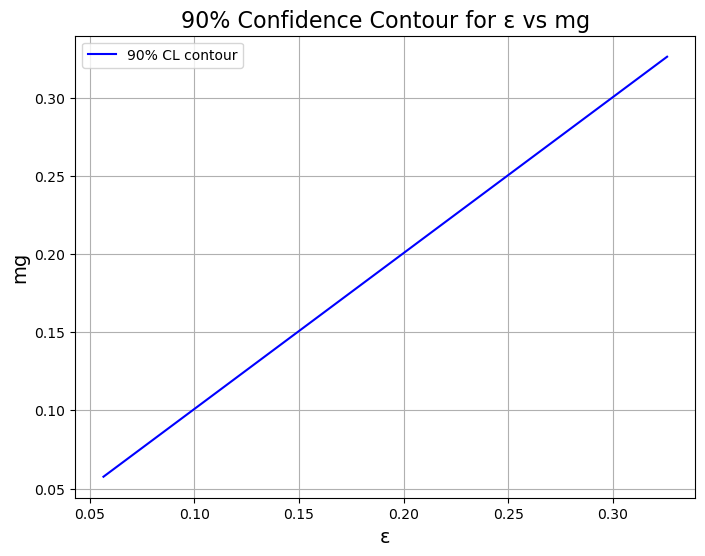

In [16]:
contour_eps_mg = m_log_atlas.mncontour('eps', 'mg', cl=0.9, size=50)

# Plot the contour
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(contour_eps_mg[0], contour_eps_mg[1], 'b-', label='90% CL contour')
plt.xlabel('ε', fontsize=14)
plt.ylabel('mg', fontsize=14)
plt.title('90% Confidence Contour for ε vs mg', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [19]:
def plot_profile_likelihood(m, param_name, cl=0.9):
    """Calculate and plot profile likelihood for a parameter"""
    # Calculate profile likelihood
    x, y = m.mnprofile(param_name, bound=3, size=100)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'b-', linewidth=2)
    plt.axhline(y=1, color='r', linestyle='--', label=f'{cl*100:.0f}% CL')
    plt.xlabel(param_name, fontsize=14)
    plt.ylabel('Δχ²', fontsize=14)
    plt.title(f'Profile Likelihood for {param_name}', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage after optimization:
plot_profile_likelihood(m_log_atlas, 'eps', cl=0.9)
plot_profile_likelihood(m_log_atlas, 'mg', cl=0.9)

ValueError: too many values to unpack (expected 2)

In [ ]:
import seaborn as sns
import pandas as pd

def plot_correlation_matrix(m):
    """Plot correlation matrix of parameters"""
    # Get parameter names and correlation matrix
    params = list(m.parameters)
    corr_matrix = m.covariance.correlation()
    
    # Create DataFrame for better labeling
    df_corr = pd.DataFrame(corr_matrix, index=params, columns=params)
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                fmt='.2f', linewidths=0.5)
    plt.title('Parameter Correlation Matrix', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_correlation_matrix(m_log_atlas)

In [ ]:
def visualize_minuit_results(m, cl=0.9):
    """Complete visualization of Minuit results"""
    params = m.parameters
    
    # 1. Print basic fit results
    print("\n=== Fit Results ===")
    print(m.params.to_table())
    
    # 2. Plot profile likelihoods
    print("\n=== Profile Likelihoods ===")
    for param in params:
        plot_profile_likelihood(m, param, cl=cl)
    
    # 3. Plot correlation matrix
    print("\n=== Correlation Matrix ===")
    plot_correlation_matrix(m)
    
    # 4. Plot contours for all parameter pairs
    print("\n=== Confidence Contours ===")
    n_params = len(params)
    for i in range(n_params):
        for j in range(i+1, n_params):
            p1, p2 = params[i], params[j]
            try:
                contour = m.mncontour(p1, p2, cl=cl, size=50)
                plt.figure(figsize=(8, 6))
                plt.plot(contour[0], contour[1], 'b-')
                plt.xlabel(p1, fontsize=14)
                plt.ylabel(p2, fontsize=14)
                plt.title(f'{cl*100:.0f}% CL Contour: {p1} vs {p2}', fontsize=16)
                plt.grid(True)
                plt.show()
            except Exception as e:
                print(f"Could not compute contour for {p1} vs {p2}: {str(e)}")

# Example usage:
visualize_minuit_results(m_log_atlas, cl=0.9)